In [13]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
def get_image(img_path, imsize=(300, 300), transform=None):
    image = Image.open(img_path)
    image = image.resize(imsize, Image.Resampling.LANCZOS)
    if transform is not None:
        image = transform(image).unsqueeze(0)
    return image.to(device)

In [16]:
def get_gram(m):
    _, c, h, w = m.size() # batch size(=1) is excluded
    mat = m.view(c, h * w)
    gram = torch.mm(mat, mat.t())
    return gram

In [17]:
def denormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1) # Standard ImageNet mean
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1) # Standard ImageNet std
    img = img * std + mean
    return img.clamp(0, 1)

In [18]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.selected_layers = [3, 8, 15, 22, 29]
        self.vgg = models.vgg16(weights='VGG16_Weights.DEFAULT').features
    
    def forward(self, x):
        layer_features = []
        for i, layer in self.vgg._modules.items():
            x = layer(x)
            if int(i) in self.selected_layers:
                layer_features.append(x)
        return layer_features

In [19]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
content_image = get_image("images/content.jpg", transform=img_transform)
style_image = get_image("images/style.jpg", transform=img_transform)

In [20]:
generated_image = content_image.clone().requires_grad_(True)

In [21]:
optimizer = torch.optim.Adam([generated_image], lr=0.003, betas=(0.5, 0.999))
encoder = FeatureExtractor().to(device)

In [22]:
for p in encoder.parameters():
    p.requires_grad_(False)
# or, encoder.eval()

In [23]:
content_weight = 1
style_weight = 1e6

for epoch in range(500):
    content_features = encoder(content_image)
    style_features = encoder(style_image)
    generated_features = encoder(generated_image)
    
    content_loss = (content_features[-1] - generated_features[-1]).pow(2).mean()
    
    style_loss = 0
    for gf, sf in zip(generated_features, style_features):
        _, c, h, w = gf.size() # batch size(=1) is excluded
        gram_gen = get_gram(gf)
        gram_style = get_gram(sf)
        style_loss += (gram_gen - gram_style).pow(2).mean().sqrt() / (c * c)
    
    loss = content_weight * content_loss + style_weight * style_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch + 1}, Content Loss: {content_loss.item()}, Style Loss: {style_loss.item()}, Total Loss: {loss.item()}")

Epoch: 10, Content Loss: 0.18147477507591248, Style Loss: 0.23758700489997864, Total Loss: 237587.1875
Epoch: 20, Content Loss: 0.3523518443107605, Style Loss: 0.18134011328220367, Total Loss: 181340.46875
Epoch: 30, Content Loss: 0.45149368047714233, Style Loss: 0.13646909594535828, Total Loss: 136469.546875
Epoch: 40, Content Loss: 0.49747148156166077, Style Loss: 0.10723758488893509, Total Loss: 107238.0859375
Epoch: 50, Content Loss: 0.5194828510284424, Style Loss: 0.08882934600114822, Total Loss: 88829.859375
Epoch: 60, Content Loss: 0.5359060168266296, Style Loss: 0.07617306709289551, Total Loss: 76173.609375
Epoch: 70, Content Loss: 0.5523847937583923, Style Loss: 0.06684555858373642, Total Loss: 66846.109375
Epoch: 80, Content Loss: 0.5656837821006775, Style Loss: 0.05973384901881218, Total Loss: 59734.4140625
Epoch: 90, Content Loss: 0.575546145439148, Style Loss: 0.054003313183784485, Total Loss: 54003.88671875
Epoch: 100, Content Loss: 0.5840200781822205, Style Loss: 0.04940

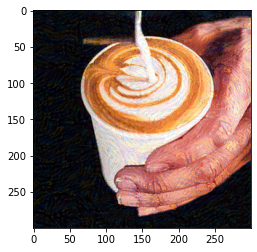

In [24]:
inp = generated_image.detach().squeeze().cpu()
inp = denormalize(inp)
inp = inp.permute(1, 2, 0)
plt.imshow(inp)